In [2]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


Label is: 0


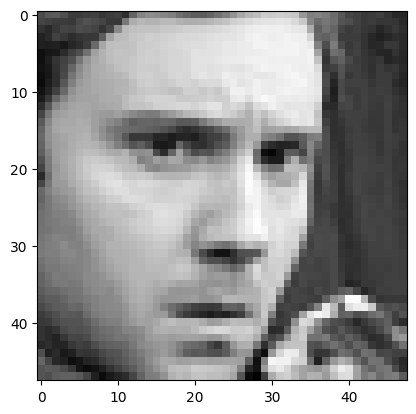

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

# Show some image
image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

In [4]:
#%tensorflow_version 2.x
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow import reshape
from collections import OrderedDict

"""
Assume we have 3 clients, each client has 5 images to train
"""

# Assume each client has 5 images to train
TRAIN_DATA_PER_CLIENT = 5

# Train 3 times for each image
TRAINING_EPOCHS = 3

# Prepare training data for each client
x_client_1 = x_train[0 : TRAIN_DATA_PER_CLIENT]
y_client_1 = y_train[0 : TRAIN_DATA_PER_CLIENT]

x_client_2 = x_train[TRAIN_DATA_PER_CLIENT : TRAIN_DATA_PER_CLIENT * 2]
y_client_2 = y_train[TRAIN_DATA_PER_CLIENT : TRAIN_DATA_PER_CLIENT * 2]

x_client_3 = x_train[TRAIN_DATA_PER_CLIENT * 2 : TRAIN_DATA_PER_CLIENT * 3]
y_client_3 = y_train[TRAIN_DATA_PER_CLIENT * 2 : TRAIN_DATA_PER_CLIENT * 3]
print(x_client_3.shape)

# Prepare test data
x_test = x_train[TRAIN_DATA_PER_CLIENT * 3 : TRAIN_DATA_PER_CLIENT * 4]
y_test = y_train[TRAIN_DATA_PER_CLIENT * 3 : TRAIN_DATA_PER_CLIENT * 4]

# Create federated data
def create_federated_data(x_train, y_train):

    orderDict = OrderedDict()
    pixels_list = []
    
    x_train = x_train / 255.0
    x_train = x_train.reshape(len(x_train), 48, 48, 1)

    orderDict['x'] = numpy.array(x_train)
    orderDict['y'] = numpy.array(y_train)
    dataset = tf.data.Dataset.from_tensor_slices(orderDict)
    batch = dataset.shuffle(10).batch(5)

    return batch

federated_data_client_1 = [create_federated_data(x_client_1, y_client_1) for epoch in range(TRAINING_EPOCHS)]
federated_data_client_2 = [create_federated_data(x_client_2, y_client_2) for epoch in range(TRAINING_EPOCHS)]
federated_data_client_3 = [create_federated_data(x_client_3, y_client_3) for epoch in range(TRAINING_EPOCHS)]

federated_data_test = [create_federated_data(x_test, y_test) for epoch in range(TRAINING_EPOCHS)]

print('Total training epochs: {}'.format(len(federated_data_client_3)))

Tensorflow version: 2.10.0
(5, 48, 48)
Total training epochs: 3


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

def create_keras_model():

    # Create keras model
    model = Sequential()

    # 1st convolution layer
    model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # 2nd convolution layer
    model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # 3rd convolution layer
    model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # 4th convolution layer
    model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(loss=SparseCategoricalCrossentropy(),
                  optimizer=SGD(learning_rate=0.02),
                  metrics=[SparseCategoricalAccuracy()])
    
    return model

# Summary model
keras_model = create_keras_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                        

In [6]:
import tensorflow_federated as tff

# Create dummy batch
dummy_batch = tf.nest.map_structure(lambda x: x.numpy(), iter(federated_data_client_1[0]).next())
print(dummy_batch['x'].shape)

def create_federated_model():

    # Create keras model
    keras_model = create_keras_model()
    
    # Convert keras model to federated model
    return tff.learning.from_compiled_keras_model(keras_model, dummy_batch)

ModuleNotFoundError: No module named 'tensorflow_federated'